#**Tutorial 5: Calculating Anomaly - Precipitation**

> Indented block

> Indented block




**Week #, Day #, Name of the day**

**Content creators:** Douglas Rao

**Content reviewers:** TBD

**Content editors:** TBD

**Production editors:** TBD

**Our 2023 Sponsors:** TBD

#**Tutorial Objectives**

In this tutorial, you will learn how to calculate anomaly using satellite climate data records for climate applications.

By the end of this tutorial you will be able to:

* Calculate the anomaly data against a specific climatology
* Calculate rolling mean of the anomaly data to smooth the time series and extract long-term signals/patterns


#**Setup**



In this section, we have:


1.   **Import cell:** imports all libraries you use in the tutorial.
2.   **Hidden Figure settings cell:** sets up the plotting style (copy exactly)
1.   **Hidden Plotting functions cell:** contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
2.   **Hidden Helper functions cell:** This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).
    



In [ ]:
#Imports

# Import only the libraries/objects that you use in this tutorial. 

# If any external library has to be installed, !pip install library --quiet
# follow this order: numpy>matplotlib. 
# import widgets in hidden Figure settings cell

!pip install s3fs --quiet

# Properly install cartopy in colab to avoid session crash
!apt-get install libproj-dev proj-data proj-bin --quiet
!apt-get install libgeos-dev --quiet
!pip install cython --quiet
!pip install cartopy --quiet

!apt-get -qq install python-cartopy python3-cartopy  --quiet
!pip uninstall -y shapely  --quiet
!pip install shapely --no-binary shapely  --quiet

import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy, cartopy.crs as ccrs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.2 MB/s eta 0:00:00
Reading package lists...
Building dependency tree...
Reading state information...
libproj-dev is already the newest version (7.2.1-1~focal0).
libproj-dev set to manually installed.
proj-data is already the newest version (7.2.1-1~focal0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 170 kB of archives.
After t

In [ ]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")


#**Section 1: From Climatology to Anomaly**

The above section header should be a description of what the section covers.



In [ ]:
# @title Video 1: Video 1 Name 
#Tech team will add code to format and display the video

Anomaly describes the departure of the current weather condition away from the normal condition (i.e., climatology) of this time. For example, if the normal January temperature of the city that you live in is 10 °C and the January temperature of this year is 15 °C. We usually say the temperature anomaly of January this year is 5 °C above normal/climatology. 

Now let's calculate the anomaly of monthly precipitation using GPCP CDR data and the skills we learned from last tutorial for calculating climatology.

##**Section 1.1: Calculating Monthly Anomaly**

To calculate anomaly, we first need to calculate the monthly climatology. Since we already learned it during last tutorial, we will fast forward this step. 

In [ ]:
# Connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
fs = s3fs.S3FileSystem(anon=True)

# Get the list of all data files in the AWS S3 bucket
file_pattern = 'noaa-cdr-precip-gpcp-monthly-pds/data/*/gpcp_v02r03_monthly_*.nc'
file_location = fs.glob(file_pattern)

# Open connection to all data files
file_ob = [fs.open(file) for file in file_location]
# Open all the monthly data files and concatenate them along the time dimension.
# This process will take ~ 1 minute to complete due to the number of data files.   
ds = xr.open_mfdataset(file_ob, combine='nested', concat_dim='time') 

In [ ]:
# Calculate climatology using `.sel()` and `.groupby()` directly.
precip_clim = ds.precip.sel(time=slice('1981-01-01', '2010-12-01')).groupby('time.month').mean(dim='time')
precip_clim

<xarray.DataArray 'precip' (month: 12, latitude: 72, longitude: 144)>
dask.array<stack, shape=(12, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of GPCP Monthly Satellite-...
    standard_name:  precipitation amount
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

Now we have the monthly precipitation climatology. How can we calculate the monthly anomaly?

The answer is straight forward - let's use `.groupby()` from `xarray`. We can split the entire time period based on the month of the year and then subtract the climatology of that specific month from the monthly value and recombine the value together.

In [ ]:
# Use `.groupby()` to calculate the monthly climatology
precip_anom = ds.precip.groupby('time.month') - precip_clim
precip_anom

/usr/local/lib/python3.9/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]


<xarray.DataArray 'precip' (time: 528, latitude: 72, longitude: 144)>
dask.array<sub, shape=(528, 72, 144), dtype=float32, chunksize=(1, 72, 144), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * longitude  (longitude) float32 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

You may have noticed that there is an additional coordinate in the anomaly dataset. The additional coordinate is `month` which is a direct outcome because of the `.groupby()` action we just performed.

Since we will use the anomaly data again in the next tutorial, let's write the data out to a netCDF file to skip the calculation of it in the future. You can simply export a data array into a netCDF file using `.to_netcdf()`. It will automatically carry all the coordinates, dimensions, and relevant information into the netCDF file.

In [ ]:
# Export the GPCP monthly anomaly data comparing to the climatology period of 1981-2010.
precip_anom.to_netcdf('t5_gpcp-monthly-anomaly_1981-2010.nc')

## **Section 1.2: Examine Anomaly**

First, let's take a look at the geospatial pattern of the monthly anomaly of a selected month – January of 1979.

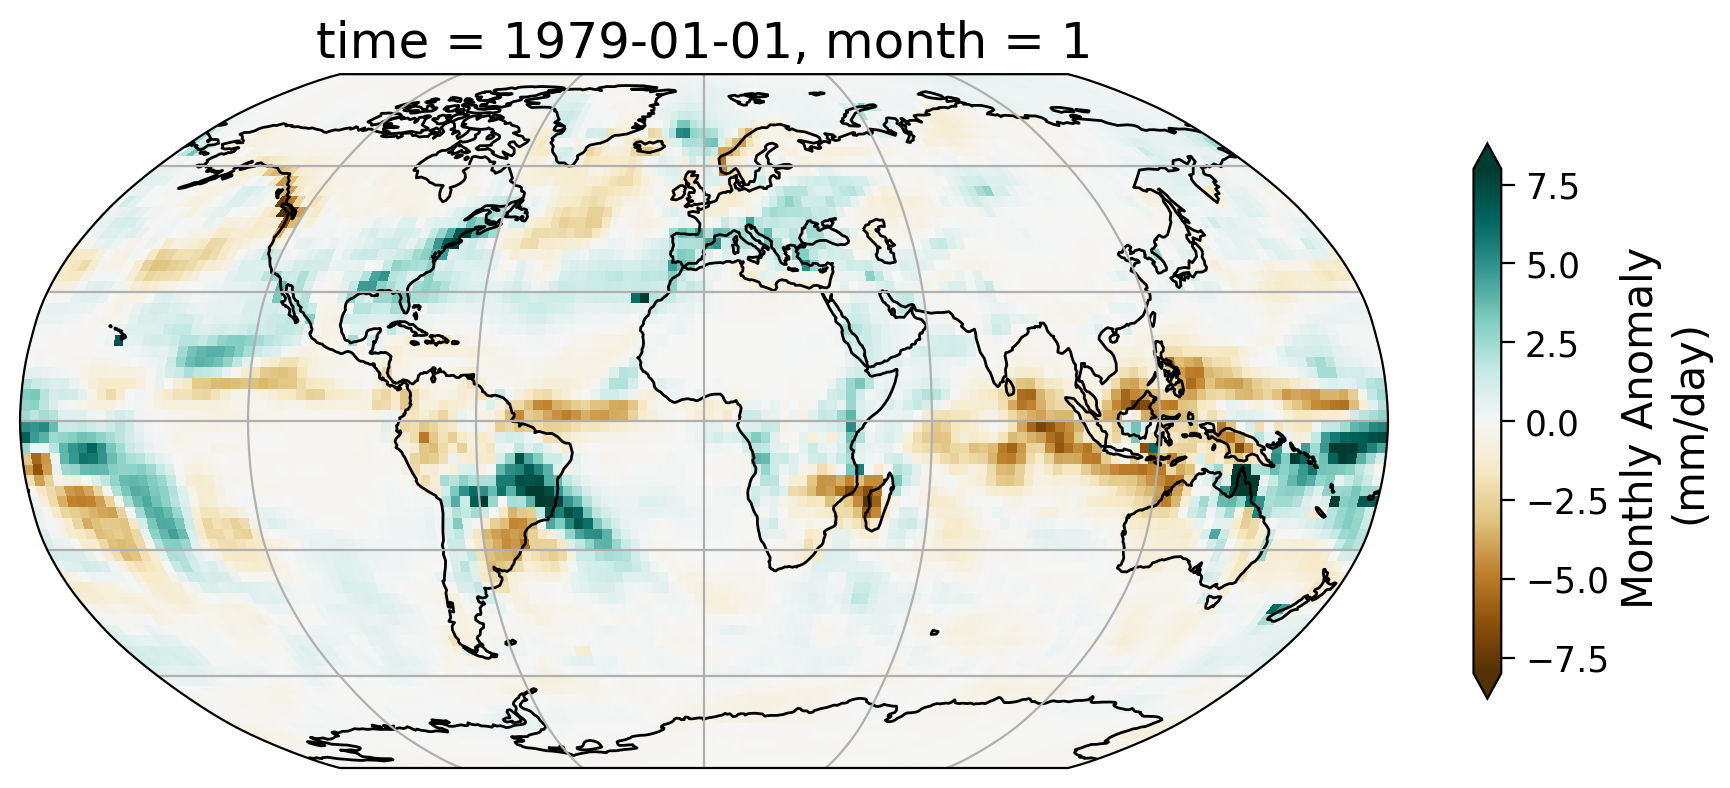

In [ ]:
# Initate plot
fig = plt.figure(figsize=(9,6))
# Set map projection
ax = plt.axes(projection=ccrs.Robinson())
# Add coastal lines to indicate land/ocean
ax.coastlines()
# Add grid lines for latitude and longitute
ax.gridlines()
# Add the precipitation data for 
precip_anom.sel(time='1979-01-01').plot(ax=ax, transform=ccrs.PlateCarree(),
                                        vmin=-8, vmax=8, cmap='BrBG',
                                        cbar_kwargs=dict(shrink=0.5, label='Monthly Anomaly \n(mm/day)'))

From the map of this monthly anomaly, we can see the spatial pattern of how precipitation for the January of 1979 has departed from the 30-year normal. Part of Amazon saw notable increase of precipitation that month as well as the northeast coast of the United States. 

We can also take a look at the time series of a selected grid. We will use the same point (0°N, 0°E) that we used before as an example to look at the monthly time series of the precipitation anomaly.

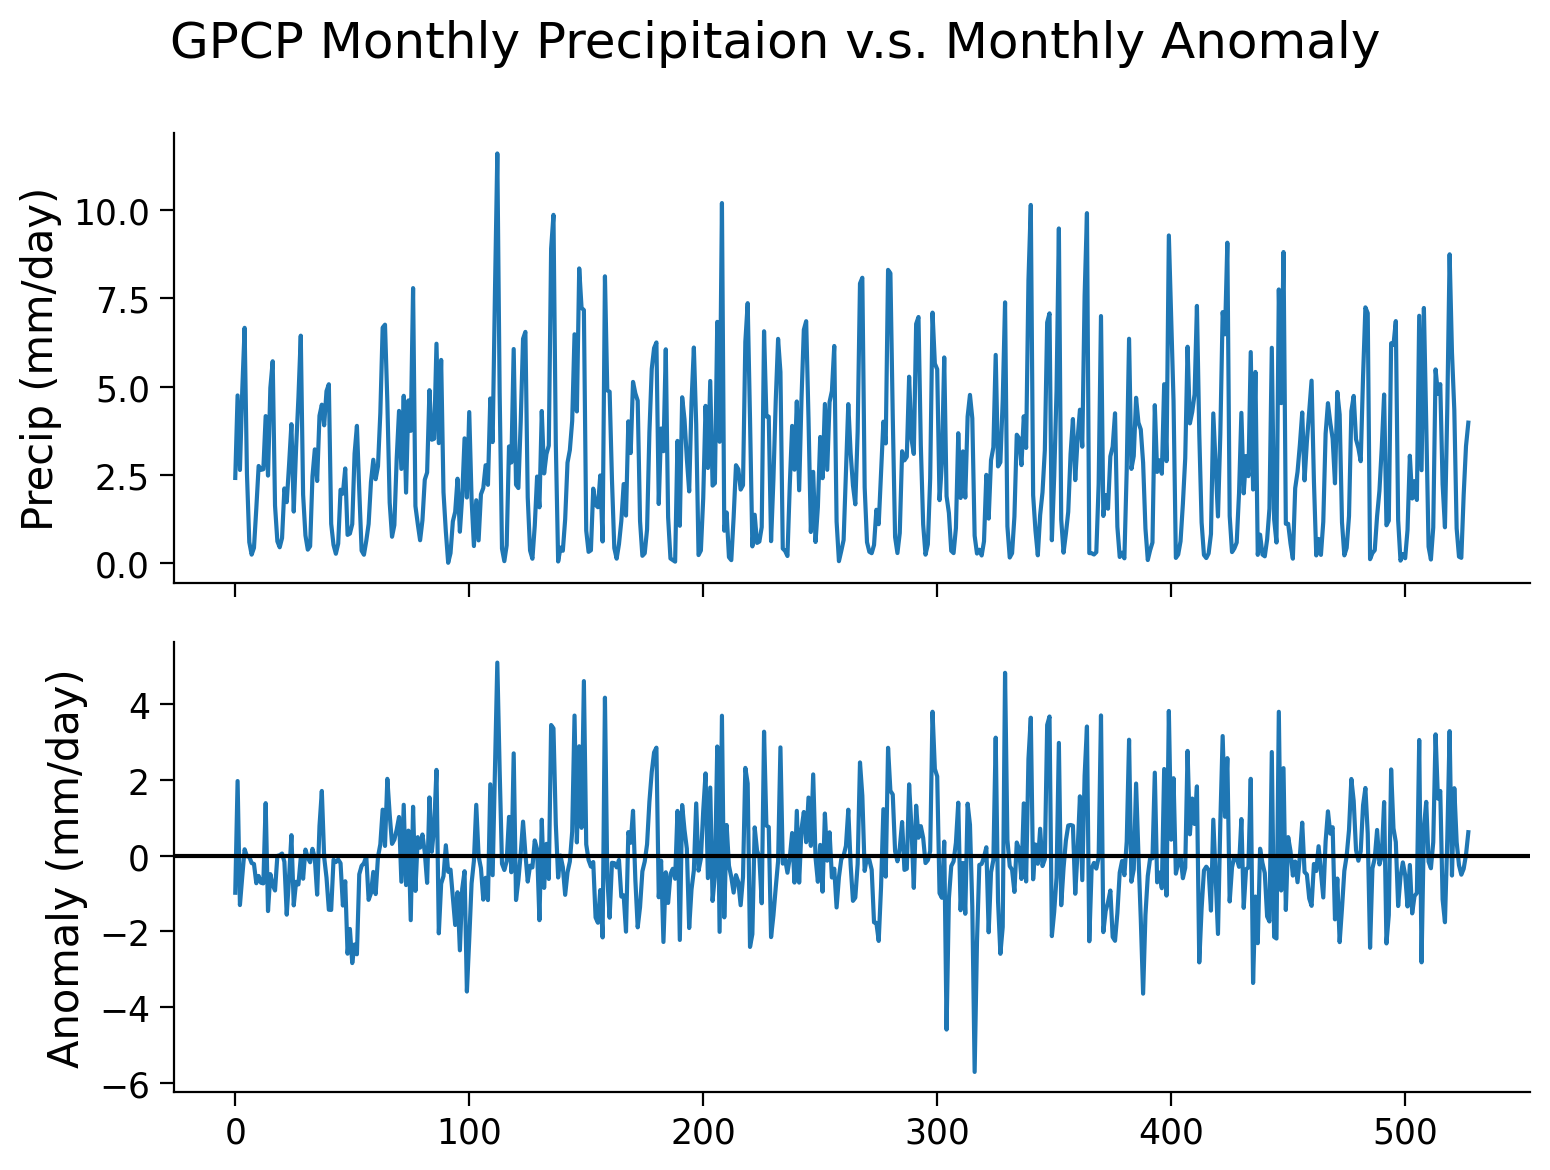

In [ ]:
# Set up two subplots that share the x-axis to compare monthly precipitation and
# monthly anomaly
fig, axs = plt.subplots(2, sharex=True)
fig.suptitle('GPCP Monthly Precipitaion v.s. Monthly Anomaly')
axs[0].plot(ds.precip.sel(latitude=0, longitude=0, method='nearest'))
axs[0].set_ylabel('Precip (mm/day)')
axs[1].plot(precip_anom.sel(latitude=0, longitude=0, method='nearest'))
axs[1].set_ylabel('Anomaly (mm/day)')
# Add horizontal line of y=0 for the anomaly subplot
axs[1].axhline(y=0, color='k', linestyle='-')

The monthly anomaly time series (lower subplot) does not seem to have obvious seasonal cycle that presented in the monthly precipitation data (upper subplot). This is one of the advantage of using anomaly data for climate analysis - we can remove the repeating pattern caused by seasonality or other stable factors. This will allow us to better focus on the signal in the data that we are interested in, e.g., climate variability or climate trend. 

## **Section 2: Anomaly Analysis**

In this section, we are going to explor a few different analysis on the anamoly data: 

- Calculating rolling mean
- Calculating global mean
- Calculating zonal mean

## **Section 2.1: Rolling Mean**

Often the monthly anomaly time series will contain noisy data that can hide the pattern caused by large-scale climate variability. We can use rolling mean to smooth the monthly time series data using `.rolling()`.

In [ ]:
# Calculate 12-month rolling mean for the selected location
grid_month = precip_anom.sel(latitude=0, longitude=0, method='nearest')
grid_rolling = grid_month.rolling(time=12, center=True).mean()

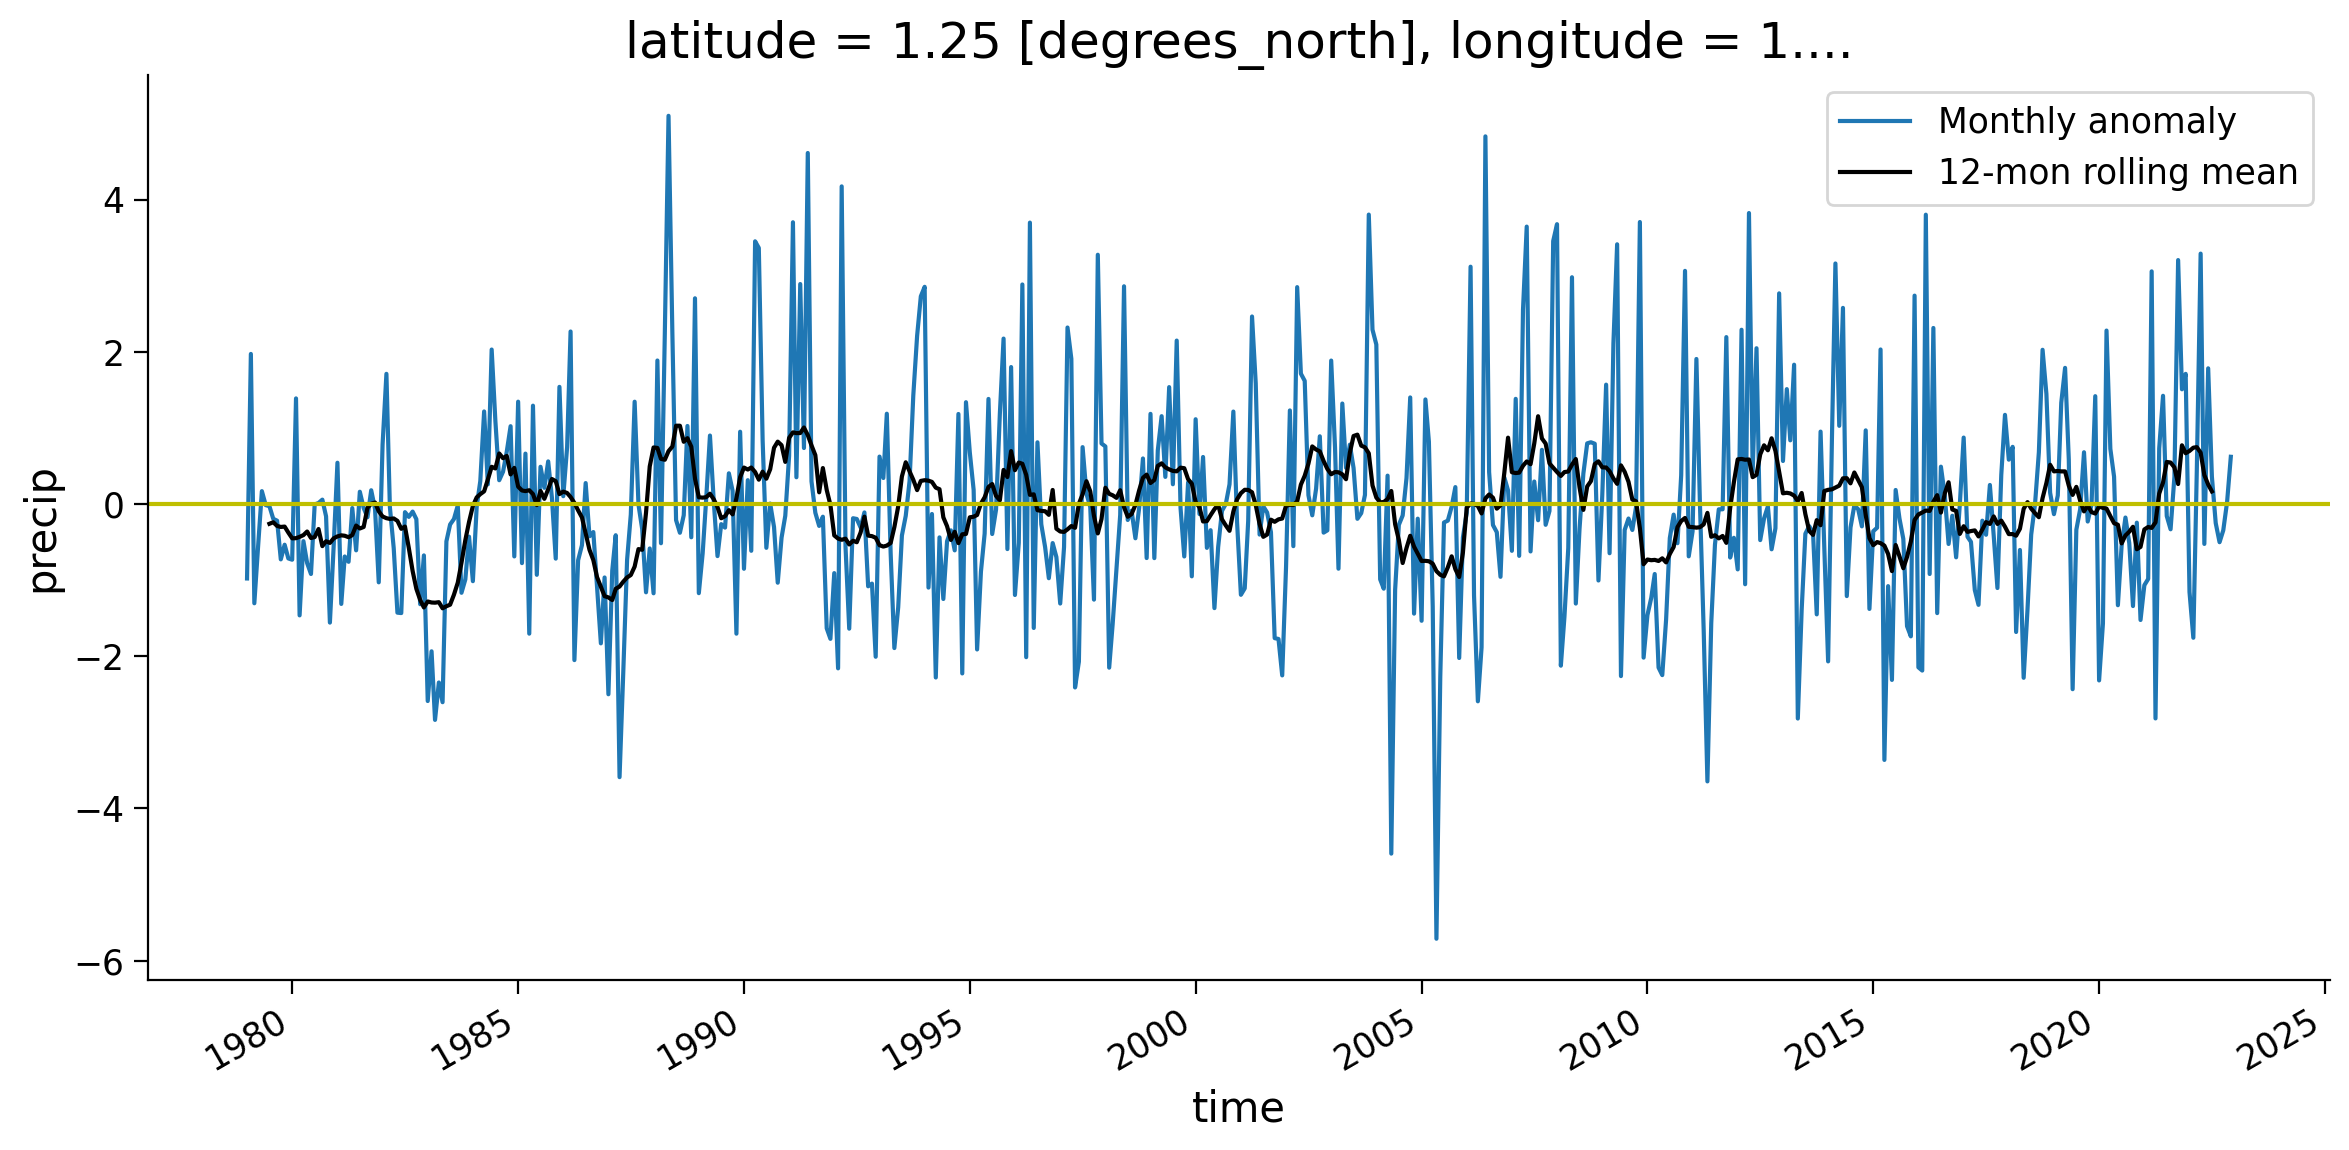

In [ ]:
# Create the time series plot of monthly anomaly
fig = plt.figure(figsize=(12,6))
grid_month.plot(label='Monthly anomaly')
grid_rolling.plot(color='k', label='12-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.legend()

As you can see, the 12-month rolling mean removed the high frequency change of monthly precipitation anomaly data while demonstrate the slow-moving change of the precipitation.

### **Exercise 2.1: 24-month rolling mean**

Can you caculate the 24-month rolling mean for the same grid and compare the three different time series (monthly anomaly, 12-month rolling mean, 24-month rolling mean)?

In [ ]:
################################################################################
# Exercise: Compare monthly anomaly with 12-month and 24-month rolling mean.   #
################################################################################

# Step 1: Extract the grid time series

# Step 2: Calculate 12-month rolling mean

# Step 3: Calculate 24-month rolling mean

# Step 4: Plot all three time series together with different colors

'''

Please describe the comparison between 12-month and 24-month rolling mean:

'''

## **Section 2.2: Global Mean**

When you want to understand the change at global scale, global mean values can be aggregated from all grids. Although each grid have same resolution of `2.5°×2.5°`, they represent different spatial areas - the same grid represent large spatial areas in the tropics than the polar region. So we want to weight the values based on its spatial areas, which is often calculated as the cosine of the latitude.

In [ ]:
# Calculate the weights using the latitude coordinates
weights = np.cos(np.deg2rad(precip_anom.latitude))
weights.name = "weights"
weights

<xarray.DataArray 'weights' (latitude: 72)>
array([0.02181496, 0.06540319, 0.10886693, 0.15212344, 0.19509035,
       0.23768592, 0.27982906, 0.32143947, 0.36243805, 0.4027467 ,
       0.4422887 , 0.48098874, 0.5187732 , 0.55557024, 0.59130967,
       0.62592345, 0.6593458 , 0.691513  , 0.72236395, 0.7518398 ,
       0.77988446, 0.8064446 , 0.8314696 , 0.85491186, 0.87672675,
       0.89687276, 0.91531146, 0.93200785, 0.9469301 , 0.96004987,
       0.9713421 , 0.98078525, 0.98836154, 0.99405634, 0.99785894,
       0.999762  , 0.999762  , 0.99785894, 0.99405634, 0.98836154,
       0.98078525, 0.9713421 , 0.96004987, 0.9469301 , 0.93200785,
       0.91531146, 0.89687276, 0.87672675, 0.85491186, 0.8314696 ,
       0.8064446 , 0.77988446, 0.7518398 , 0.72236395, 0.691513  ,
       0.6593458 , 0.62592345, 0.59130967, 0.55557024, 0.5187732 ,
       0.48098874, 0.4422887 , 0.4027467 , 0.36243805, 0.32143947,
       0.27982906, 0.23768592, 0.19509035, 0.15212344, 0.10886693,
       0.06540319, 0.02181496], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]
    axis:           Y
    bounds:         lat_bounds

In [ ]:
# Calculate weighted global monthly mean
anom_weighted = precip_anom.weighted(weights)
global_weighted_mean = anom_weighted.mean(('latitude', 'longitude'))
global_weighted_mean

<xarray.DataArray 'precip' (time: 528)>
dask.array<truediv, shape=(528,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

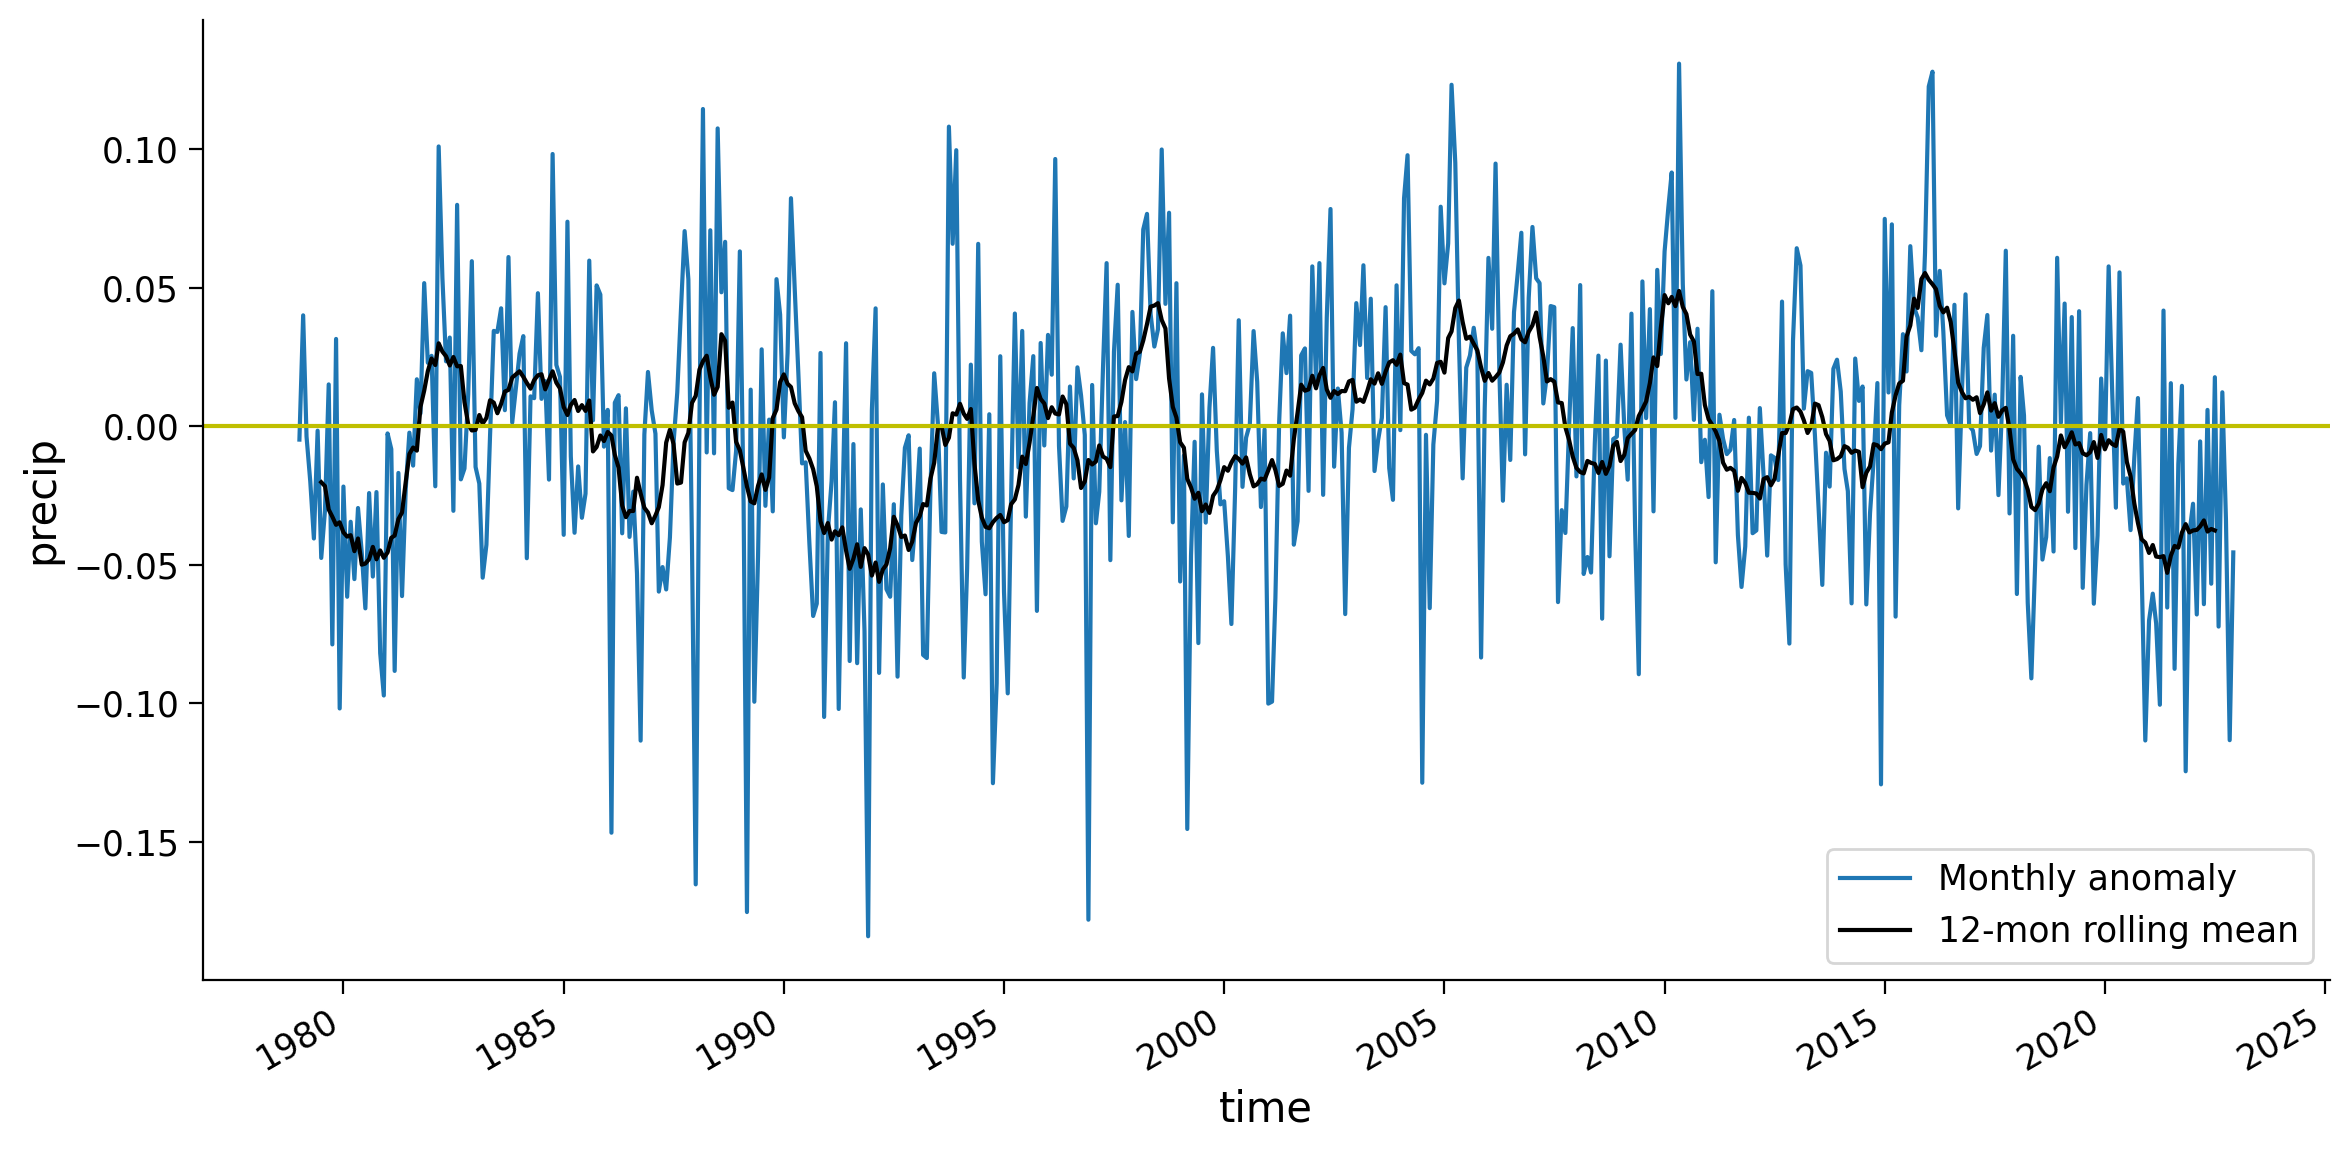

In [ ]:
# Create the time series plot of global weighted monthly anomaly
fig = plt.figure(figsize=(12,6))
global_weighted_mean.plot(label='Monthly anomaly')
global_weighted_mean.rolling(time=12, center=True).mean(('latitude', 'longitude')).plot(color='k', label='12-mon rolling mean')
plt.axhline(y=0, color='y', linestyle='-')
plt.legend()

### **Exercise 2.2: Weighted mean or unweighted global mean?**

We calculated the weighted global mean earlier. Now, you can try to explore the difference between the global weighted and unweighted mean time series. 

In [ ]:
################################################################################
# Exercise: Compare global weighted and unweighted mean time series.           #
################################################################################

# Step 1: Calculate unweighted global mean

# Step 2: Calculate different between weighted and unweighted global mean

# Step 3: Plot the time serise of the difference

'''

Please describe the difference between weighted and unweighted global mean:

'''

#**Summary**

In this tutorial, we learned how to calculate anomaly comparing to a climatology time period. This is the basis for climate monitoring and many climate applications.

* Anomaly allows us to look at the signals that may be covered by the seasonal cycle pattern (e.g., temperature/precipitation seasonal cycle).
* Anomaly data can be further smoothed using rolling mean to reveal longer-term signals at annual or decade time scale.

We will use the anomaly concept to study climate variability in the next tutorial.
